<a href="https://colab.research.google.com/github/epark21/stock/blob/master/stock_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy import arange
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import pandas as pd
from pandas import read_csv
from pandas import set_option
from pandas_datareader import data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [0]:
financial_data14 = "https://raw.githubusercontent.com/epark21/stock/master/demos/flask-sklearn/2014_Financial_Data.csv"
financial_data15 = "https://raw.githubusercontent.com/epark21/stock/master/demos/flask-sklearn/2015_Financial_Data.csv"
financial_data16 = "https://raw.githubusercontent.com/epark21/stock/master/demos/flask-sklearn/2016_Financial_Data.csv"
financial_data17 = "https://raw.githubusercontent.com/epark21/stock/master/demos/flask-sklearn/2017_Financial_Data.csv"
financial_data18 = "https://raw.githubusercontent.com/epark21/stock/master/demos/flask-sklearn/2018_Financial_Data.csv"

Initial Dataframe Construction

In [0]:
df14 = pd.read_csv(financial_data14)
df15 = pd.read_csv(financial_data15)
df16 = pd.read_csv(financial_data16)
df17 = pd.read_csv(financial_data17)
df18 = pd.read_csv(financial_data18)

In [0]:
df14['Year'] = 2014
df14 = df14.rename(columns={"2015 PRICE VAR [%]": "Price"})
df15['Year'] = 2015
df15 = df15.rename(columns={"2016 PRICE VAR [%]": "Price"})
df16['Year'] = 2016
df16 = df16.rename(columns={"2017 PRICE VAR [%]": "Price"})
df17['Year'] = 2017
df17 = df17.rename(columns={"2018 PRICE VAR [%]": "Price"})
df18['Year'] = 2018
df18 = df18.rename(columns={"2019 PRICE VAR [%]": "Price"})

In [0]:
#df = pd.concat([df14,df15,df16,df17,df18],axis=0,sort=False)
df=df18

In [0]:
df = df.rename(columns={'Unnamed: 0':'Name'})
#df['Year'] = df['Year'].astype('str')
#df['Name'] = df['Name'].astype('str')+'-'+df['Year']
df.head()

,Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,...,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Price,Class,Year
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,0.1599,0.1241,3.814000e+09,0.000000e+00,3.814000e+09,1.110400e+10,0.000000e+00,2.184800e+10,4.443700e+10,1.676230e+11,...,0.0000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.4840,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.1928,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1,2018
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,0.000000e+00,3.280000e+09,1.498000e+09,3.850000e+08,5.722000e+09,3.789700e+10,2.484500e+10,...,34.9666,0.0478,-1.3195,0.0564,0.0405,0.0751,53.8519,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,NaN,-0.1402,-0.0104,NaN,-0.1057,-0.0215,NaN,-0.0881,0.8445,NaN,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1,2018
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,0.3291,0.2972,3.019000e+09,8.631000e+09,1.165000e+10,6.722000e+09,7.253000e+09,2.878700e+10,4.897600e+10,3.634900e+10,...,9.9534,0.2824,-3.2923,0.1187,0.1203,0.2917,1.1928,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.1719,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1,2018
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.43

In [0]:
df = df.set_index(df['Name'])

In [0]:
df.shape

(4392, 226)

In [0]:
df = df.drop(labels=['Year'],axis=1)

In [0]:
df.loc[:, df.dtypes == object]

,Name,Sector
Name,,
CMCSA,CMCSA,Consumer Cyclical
KMI,KMI,Energy
INTC,INTC,Technology
MU,MU,Technology
GE,GE,Industrials
...,...,...
YRIV,YRIV,Real Estate
YTEN,YTEN,Basic Materials
ZKIN,ZKIN,Basic Materials


# Data Cleaning


Credit Nicolas Carbone and his pulic notebook at https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset for much of the code and ideas of how to best clean and set up this data set.

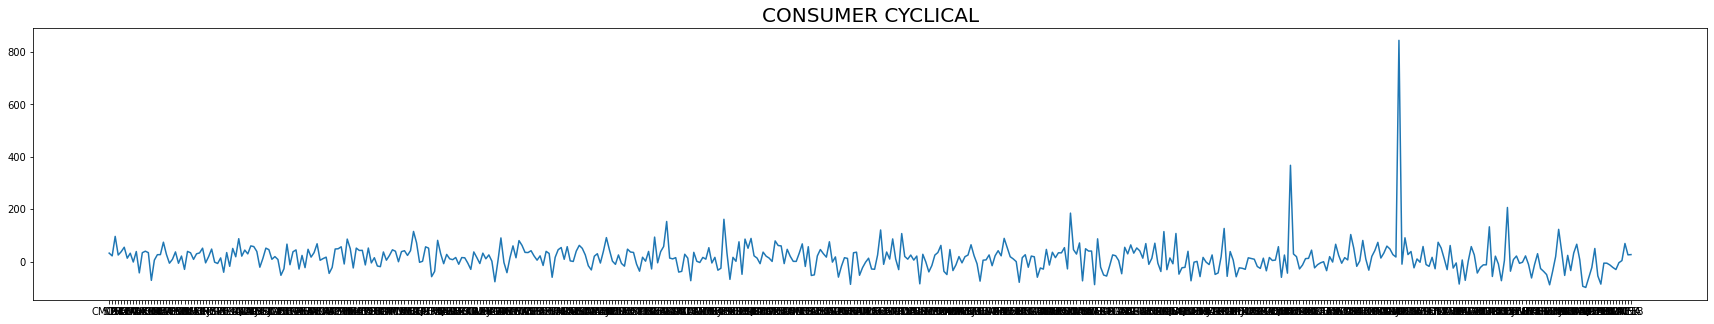

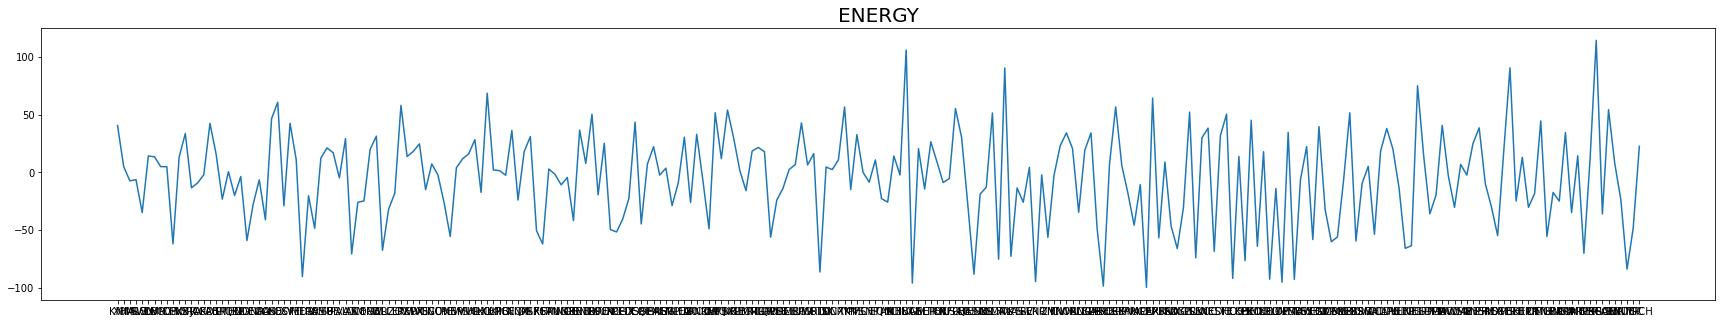

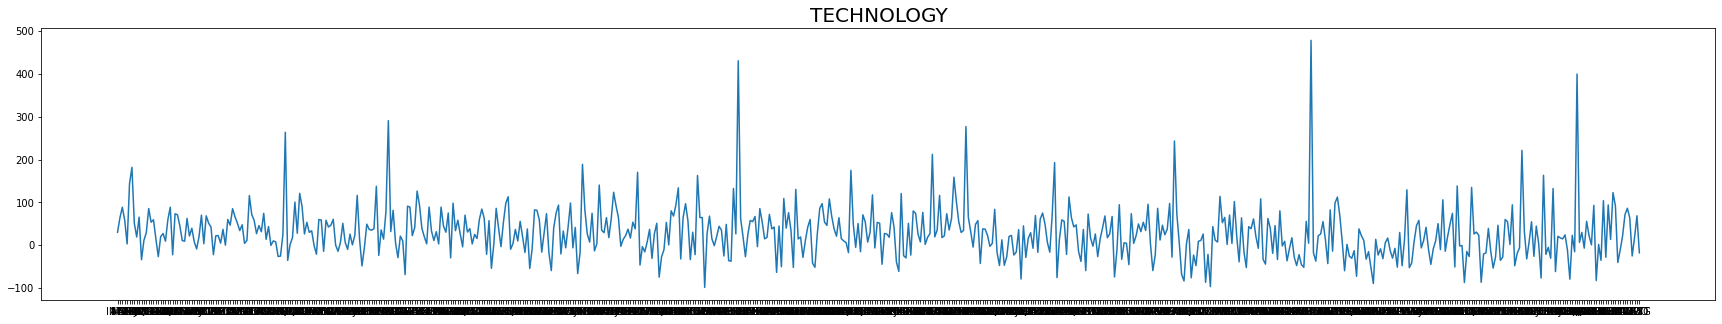

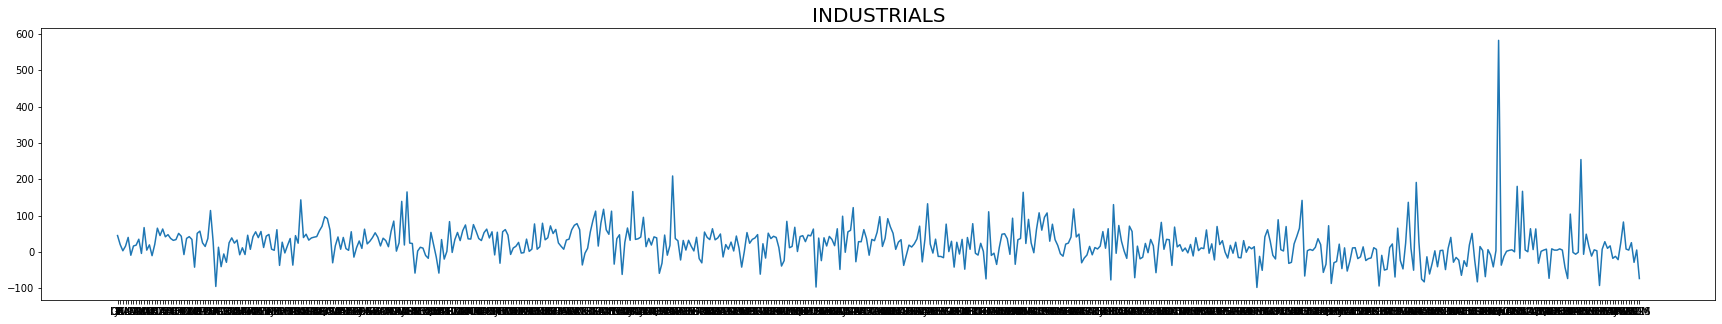

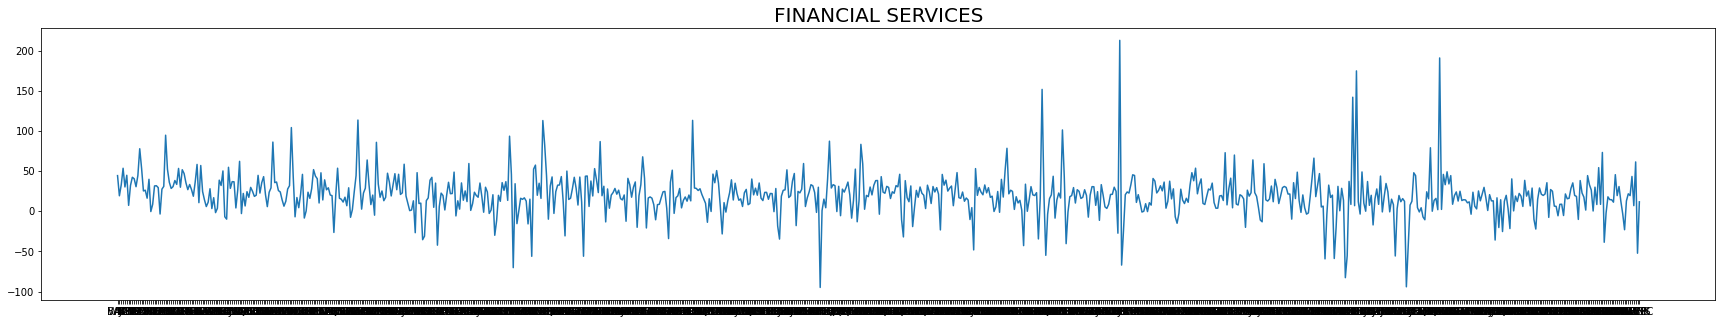

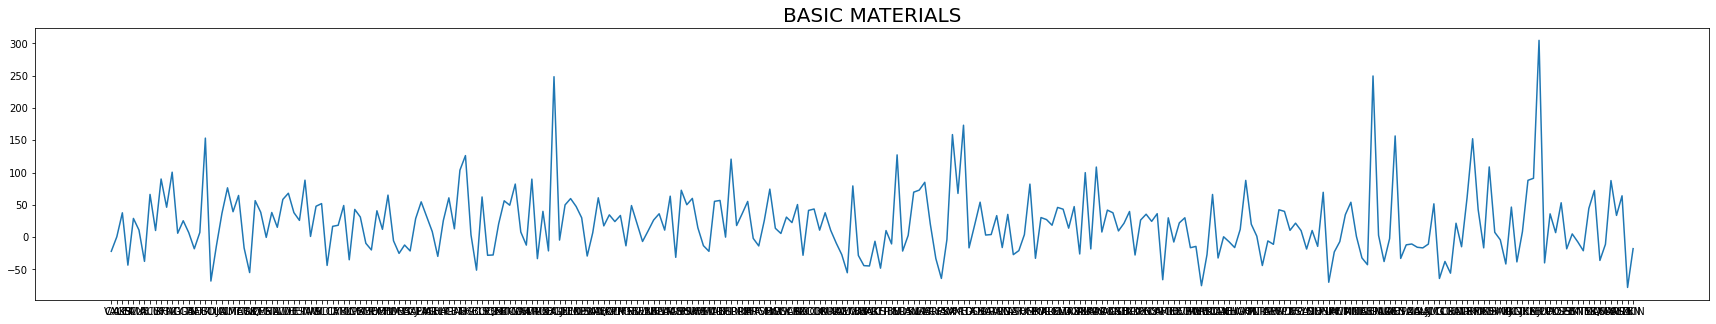

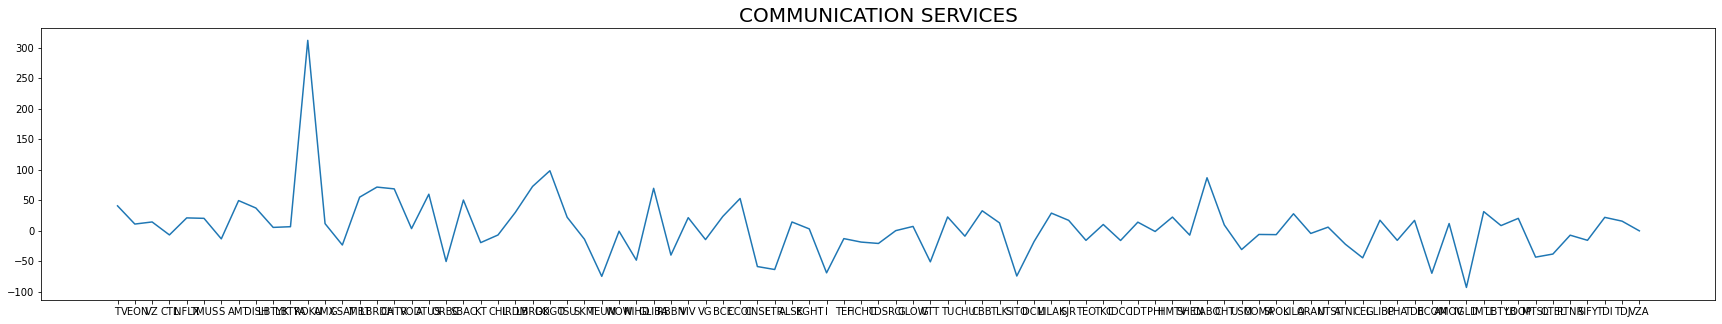

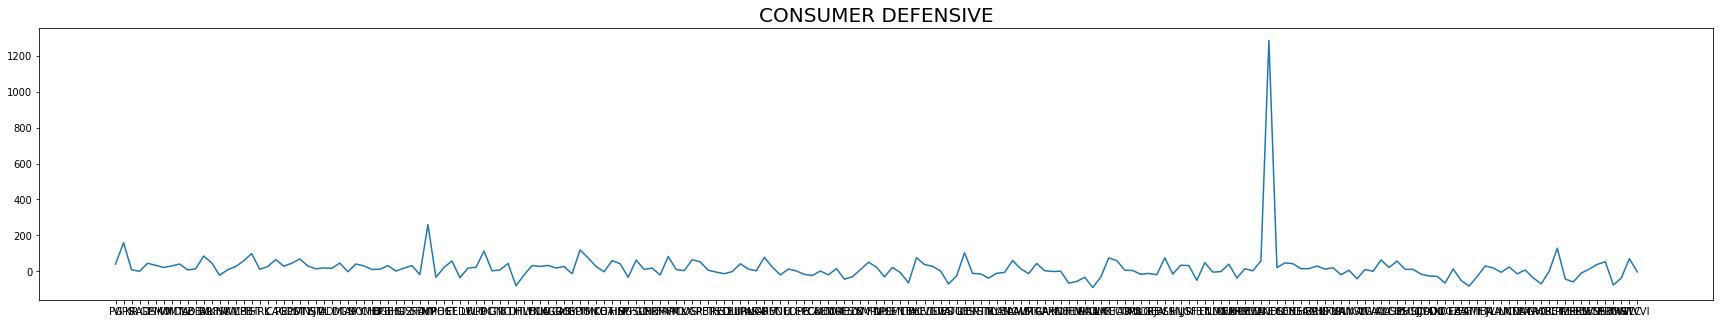

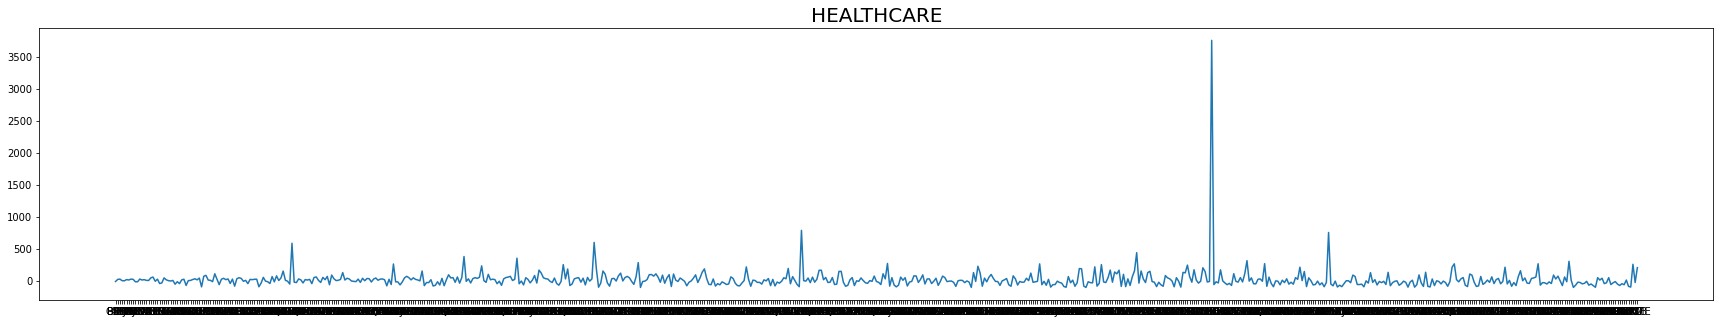

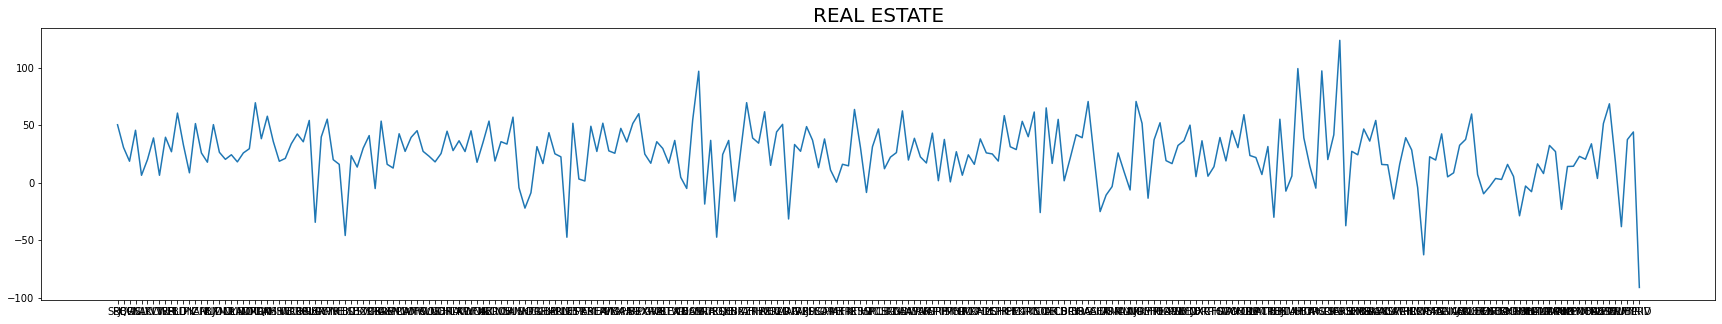

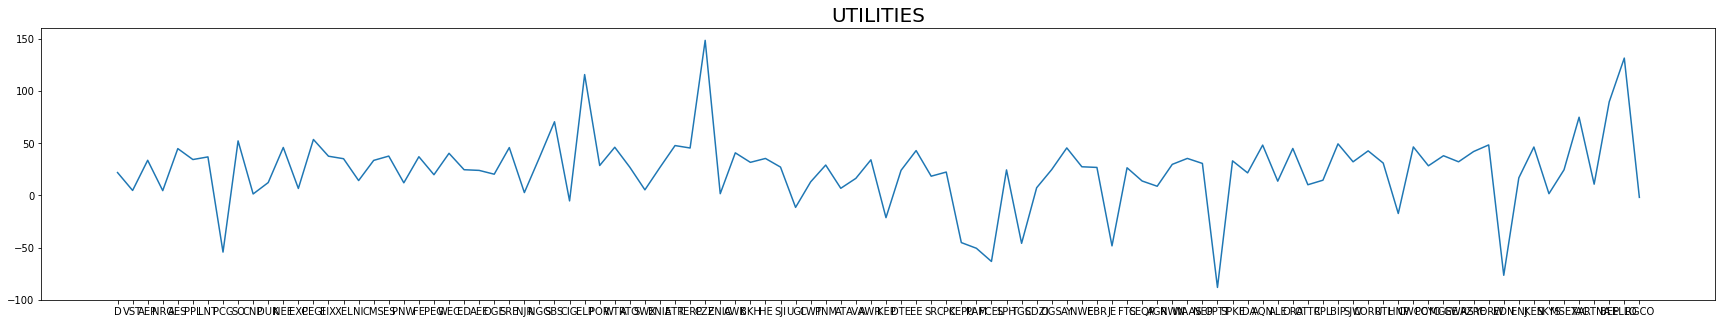

In [0]:
df_ = df[['Sector', 'Price']]

# Get list of sectors
sector_list = df_['Sector'].unique()

# Plot the percent price variation for each sector
for sector in sector_list:
    
    temp = df_[df_['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp['Price'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

In [0]:
# Get stocks that increased more than 500%
gain = 500
top_gainers = df_[df_['Price'] >= gain]
top_gainers = top_gainers['Price'].sort_values(ascending=False)
print(f'{len(top_gainers)} STOCKS with more than {gain}% gain.')
print()

8 STOCKS with more than 500% gain.



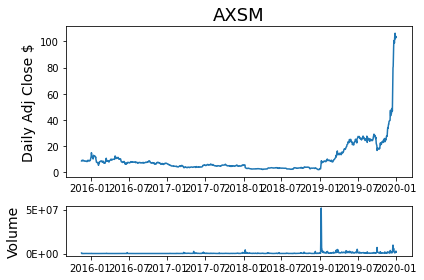

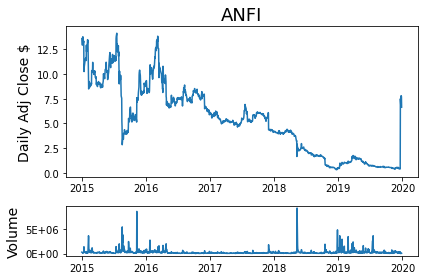

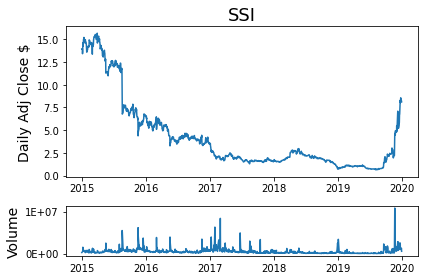

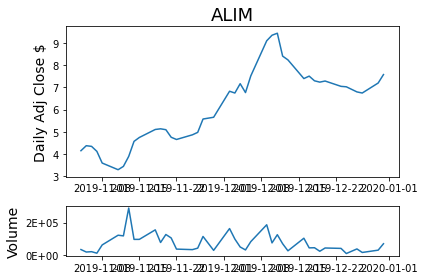

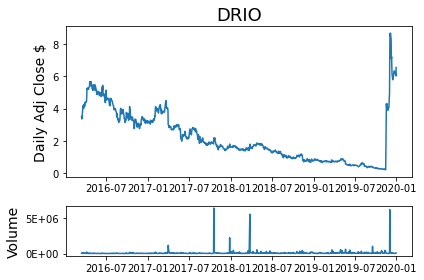

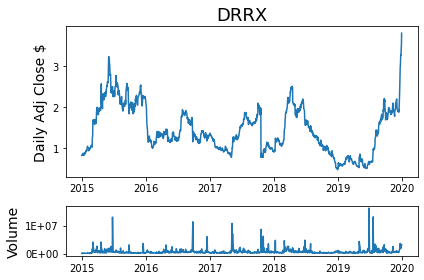

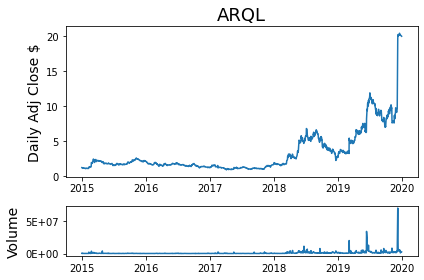

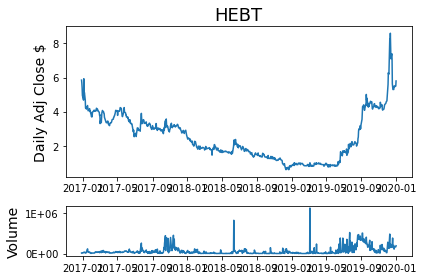

In [0]:
# Set
date_start = '01-01-2015'
date_end = '12-31-2019'
tickers = top_gainers.index.values.tolist()

for ticker in tickers:
    
    # Pull daily prices for each ticker from Yahoo Finance
    daily_price = data.DataReader(ticker, 'yahoo', date_start, date_end)
    
    # Plot prices with volume
    fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
    
    ax0.plot(daily_price['Adj Close'])
    ax0.set_title(ticker, fontsize=18)
    ax0.set_ylabel('Daily Adj Close $', fontsize=14)
    ax1.plot(daily_price['Volume'])
    ax1.set_ylabel('Volume', fontsize=14)
    ax1.yaxis.set_major_formatter(
            matplotlib.ticker.StrMethodFormatter('{x:.0E}'))

    fig.align_ylabels(ax1)
    fig.tight_layout()
    plt.show()

There is a lot of volatility throughout the data.  And potential growth that is attributed to things like trading freezes rather than performance or optimism surrounding a company.  Stocks with "inorganic" growth need to be identified and removed as they are outliers.

In [0]:
inorganic_stocks = tickers
df.drop(inorganic_stocks, axis=0, inplace=True)

We expect volitility, but stocks with vertical spikes accompanied by low trade activity, is suspect growth and not indicitive of a companies performance or other factor.

In [0]:
df.shape

(4384, 225)

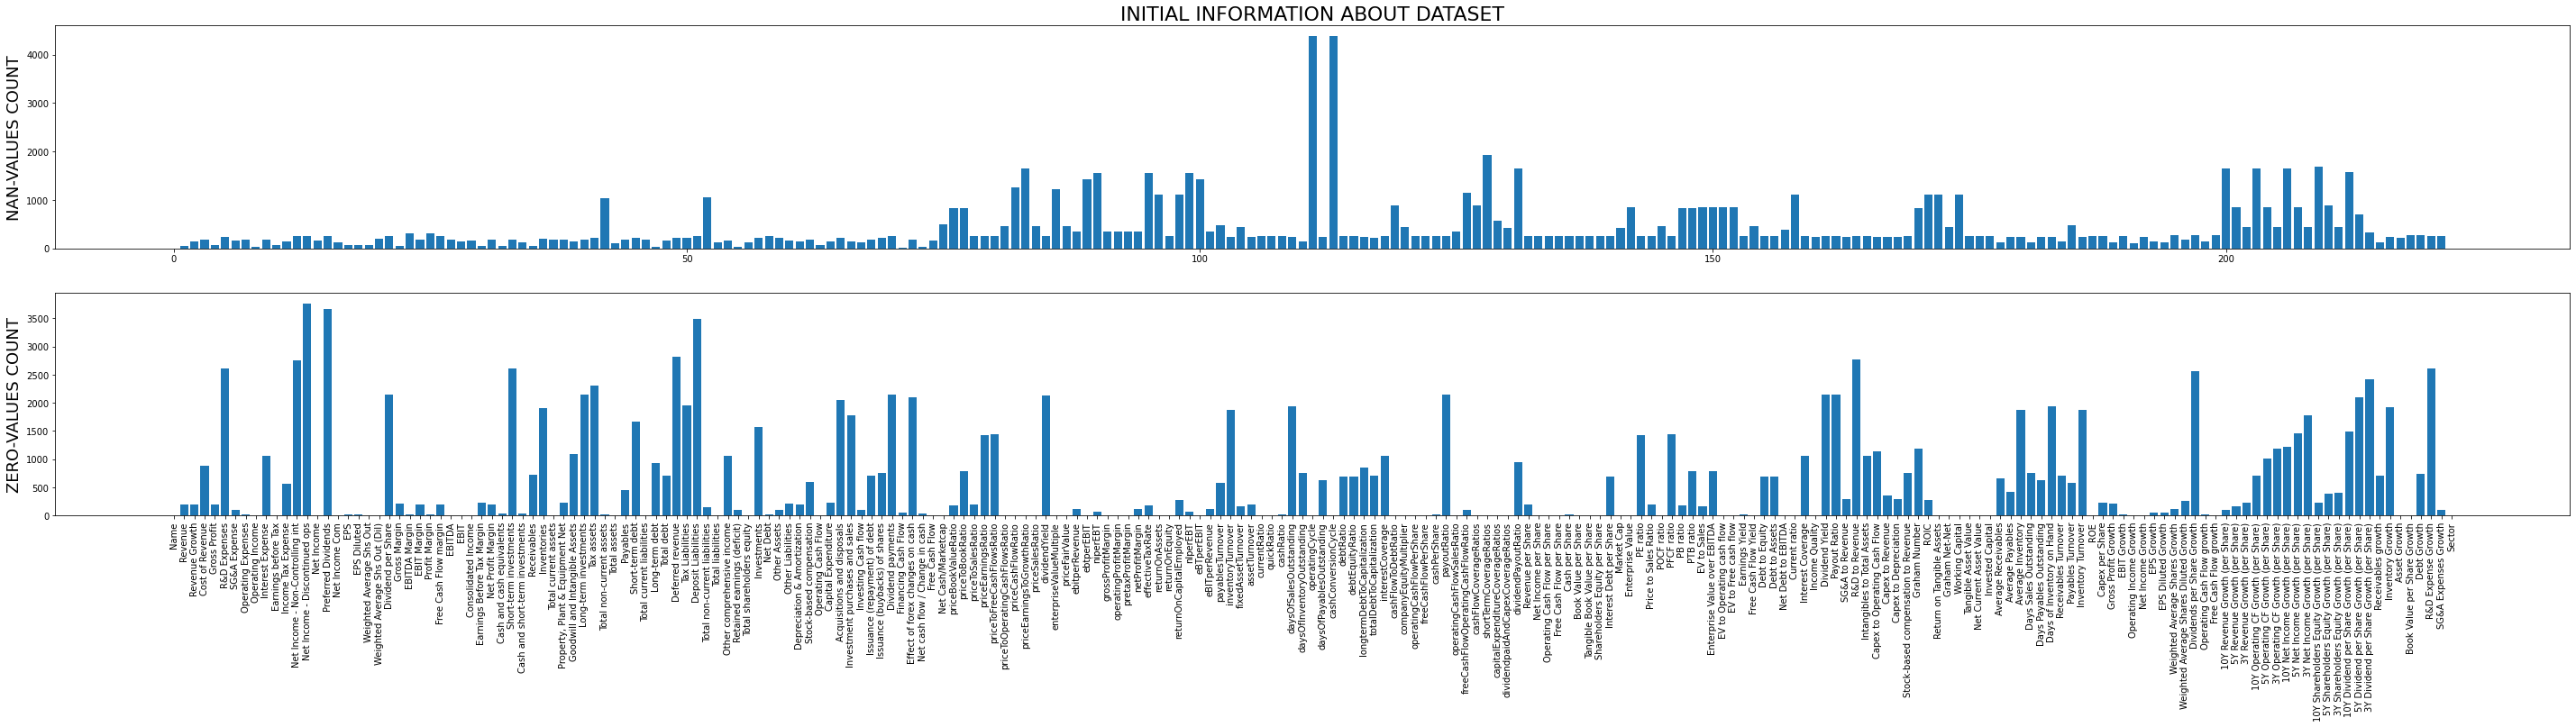

In [0]:
# Drop columns relative to classification, we will use them later
class_data = df.loc[:, ['Class', 'Price']]
df.drop(['Class', 'Price'], inplace=True, axis=1)

# Plot initial status of data quality in terms of nan-values and zero-values
nan_vals = df.isna().sum()
zero_vals = df.isin([0]).sum()
ind = np.arange(df.shape[1])

plt.figure(figsize=(50,10))

plt.subplot(2,1,1)
plt.title('INITIAL INFORMATION ABOUT DATASET', fontsize=22)
plt.bar(ind, nan_vals.values.tolist())
plt.ylabel('NAN-VALUES COUNT', fontsize=18)

plt.subplot(2,1,2)
plt.bar(ind, zero_vals.values.tolist())
plt.ylabel('ZERO-VALUES COUNT', fontsize=18)
plt.xticks(ind, nan_vals.index.values, rotation='90')

plt.show()

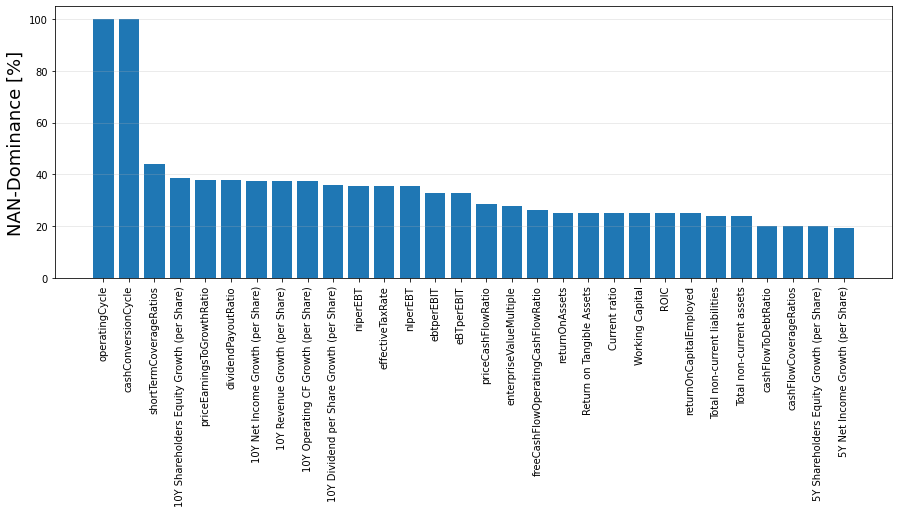

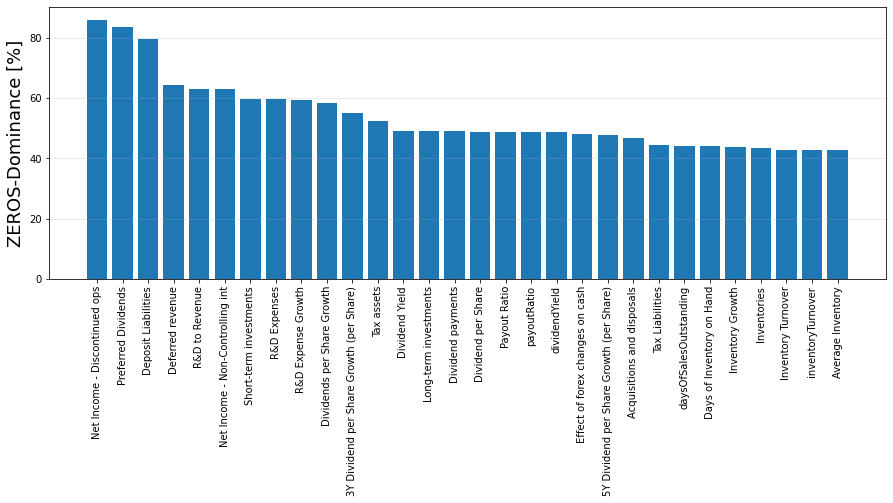

In [0]:
# Find count and percent of nan-values, zero-values
total_nans = df.isnull().sum().sort_values(ascending=False)
percent_nans = (df.isnull().sum()/df.isnull().count() * 100).sort_values(ascending=False)
total_zeros = df.isin([0]).sum().sort_values(ascending=False)
percent_zeros = (df.isin([0]).sum()/df.isin([0]).count() * 100).sort_values(ascending=False)
df_nans = pd.concat([total_nans, percent_nans], axis=1, keys=['Total NaN', 'Percent NaN'])
df_zeros = pd.concat([total_zeros, percent_zeros], axis=1, keys=['Total Zeros', 'Percent Zeros'])

# Graphical representation
plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_nans['Percent NaN'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_nans['Percent NaN'].iloc[:30].index.values.tolist(), rotation='90')
plt.ylabel('NAN-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].index.values.tolist(), rotation='90')
plt.ylabel('ZEROS-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

In [0]:
# Find reasonable threshold for nan-values situation
test_nan_level = 0.5
print(df_nans.quantile(test_nan_level))
_, thresh_nan = df_nans.quantile(test_nan_level)

# Find reasonable threshold for zero-values situation
test_zeros_level = 0.6
print(df_zeros.quantile(test_zeros_level))
_, thresh_zeros = df_zeros.quantile(test_zeros_level)

Total NaN      251.000000
Percent NaN      5.725365
Name: 0.5, dtype: float64
Total Zeros      273.600000
Percent Zeros      6.240876
Name: 0.6, dtype: float64


In [0]:
# Clean dataset applying thresholds for both zero values, nan-values
print(f'INITIAL NUMBER OF VARIABLES: {df.shape[1]}')
print()

df_test1 = df.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, 1)
print(f'NUMBER OF VARIABLES AFTER NaN THRESHOLD {thresh_nan:.2f}%: {df_test1.shape[1]}')
print()

df_zeros_postnan = df_zeros.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, axis=0)
df_test2 = df_test1.drop((df_zeros_postnan[df_zeros_postnan['Percent Zeros'] > thresh_zeros]).index, 1)
print(f'NUMBER OF VARIABLES AFTER Zeros THRESHOLD {thresh_zeros:.2f}%: {df_test2.shape[1]}')

INITIAL NUMBER OF VARIABLES: 223

NUMBER OF VARIABLES AFTER NaN THRESHOLD 5.73%: 123

NUMBER OF VARIABLES AFTER Zeros THRESHOLD 6.24%: 63


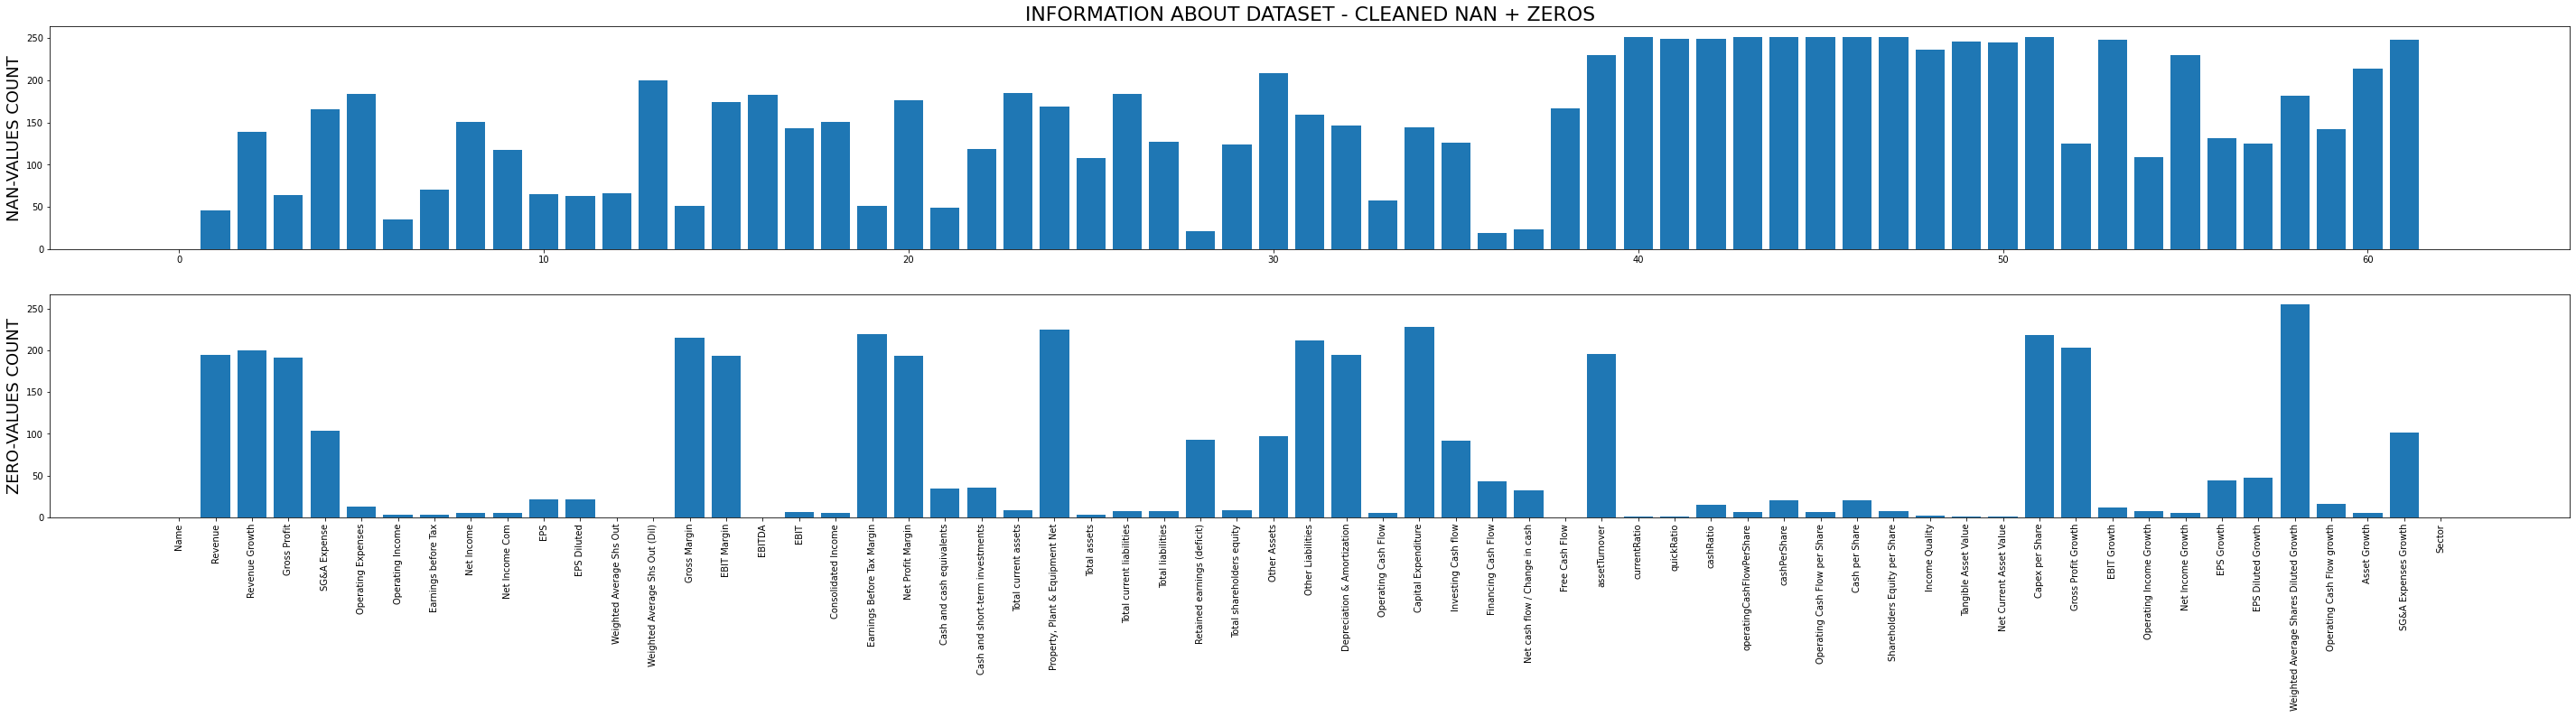

In [0]:
# New check on nan values
plt.figure(figsize=(50,10))

plt.subplot(2,1,1)
plt.title('INFORMATION ABOUT DATASET - CLEANED NAN + ZEROS', fontsize=22)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isnull().sum())
plt.ylabel('NAN-VALUES COUNT', fontsize=18)

plt.subplot(2,1,2)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isin([0]).sum())
plt.ylabel('ZERO-VALUES COUNT', fontsize=18)
plt.xticks(np.arange(df_test2.shape[1]), df_test2.columns.values, rotation='90')

plt.show()

In [0]:
top_quantiles = df_test2.quantile(0.97)
outliers_top = (df_test2 > top_quantiles)

low_quantiles = df_test2.quantile(0.03)
outliers_low = (df_test2 < low_quantiles)

df_test2 = df_test2.mask(outliers_top, top_quantiles, axis=1)
df_test2 = df_test2.mask(outliers_low, low_quantiles, axis=1)

# Take a look at the dataframe post-outliers cut
df_test2.describe()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Gross Margin,EBIT Margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Total assets,Total current liabilities,Total liabilities,Retained earnings (deficit),Total shareholders equity,Other Assets,Other Liabilities,Depreciation & Amortization,Operating Cash Flow,Capital Expenditure,Investing Cash flow,Financing Cash Flow,Net cash flow / Change in cash,Free Cash Flow,assetTurnover,currentRatio,quickRatio,cashRatio,operatingCashFlowPerShare,cashPerShare,Operating Cash Flow per Share,Cash per Share,Shareholders Equity per Share,Income Quality,Tangible Asset Value,Net Current Asset Value,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
count,4.338000e+03,4245.000000,4.320000e+03,4.218000e+03,4.200000e+03,4.349000e+03,4.313000e+03,4.233000e+03,4.267000e+03,4319.000000,4321.000000,4.318000e+03,4.184000e+03,4333.000000,4210.000000,4.201000e+03,4.241000e+03,4.233000e+03,4333.000000,4208.000000,4.335000e+03,4.265000e+03,4.199000e+03,4.215000e+03,4.276000e+03,4.200000e+03,4.257000e+03,4.363000e+03,4.260000e+03,4.176000e+03,4.225000e+03,4.238000e+03,4.326000e+03,4.240000e+03,4.258000e+03,4.365000e+03,4.360000e+03,4.217000e+03,4154.000000,4133.000000,4135.000000,4135.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4148.000000,4.138000e+03,4.140000e+03,4133.000000,4259.000000,4136.00000,4275.000000,4154.000000,4253.000000,4259.000000,4202.000000,4242.000000,4170.000000,4136.000000
mean,3.443673e+09,0.136207,1.432494e+09,6.089157e+08,9.863821e+08,4.493776e+08,3.743059e+08,3.095654e+08,3.148673e+08,1.039666,1.006833,1.420342e+08,1.422075e+08,0.517790,-0.322886,6.856524e+08,4.704467e+08,3.204341e+08,-0.365313,-0.390950,4.933210e+08,6.551131e+08,2.059447e+09,1.702931e+09,9.416925e+09,2.245201e+09,6.078215e+09,1.320655e+09,2.413378e+09,2.756585e+08,1.183552e+09,1.976842e+08,5.743150e+08,-2.300609e+08,-4.369473e+08,-1.544938e+08,5.688166e+06,3.395356e+08,0.644945,2.638606,2.097287,1.056040,3.768965,6.612721,3.768965,6.612721,21.187318,1.165719,6.696617e+09,-3.413967e+09,-2.001084,0.148115,0.14891,0.078507,0.262407,0.263677,0.257434,0.107961,0.208392,0.111732,0.111851
std,7.350918e+09,0.303394,3.268794e+09,1.396057e+09,2.226176e+09,1.103766e+09,9.660735e+08,8.030807e+08,8.189053e+08,2.932928,2.888392,2.578347e+08,2.591039e+08,0.324979,1.767010,1.565713e+09,1.123056e+09,8.224904e+08,1.785575,1.803895,1.172416e+09,1.608590e+09,4.773734e+09,4.180519e+09,2.229680e+10,5.588694e+09,1.438937e+10,4.152243e+09,5.198238e+09,7.952332e+08,3.144317e+09,4.414632e+08,1.357999e+09,5.587482e+08,1.059866e+09,8.299435e+08,2.655513e+08,9.412282e+08,0.618317,3.026445,2.712370,1.655101,7.417995,15.383548,7.417995,15.383548,36.618725,2.783555,1.559023e+10,8.792989e+09,4.305203,0.403202,1.38392,1.216322,2.028570,1.841349,1.829786,0.264321,1.270314,0.315535,0.215618
min,0.000000e+00,-0.406892,0.000000e+00,8.845586e+05,4.191690e+06,-1.800506e+08,-2.263320e+08,-2.215861e+08,-2.227011e+08,-6.039200,-6.038000,2.526447e+06,2.502535e+06,0.000000,-8.953938,-1.225210e+08,-1.682777e+08,-2.213451e+08,-9.093568,-9.191803,5.160929e+05,6.300938e+05,5.855884e+06,0.000000e+00,1.305339e+07,1.933140e+06,2.876760e+06,-1.844759e+09,-3.892036e+07,-7.302350e+07,0.000000e+00,0.000000e+00,-1.099548e+08,-2.706540e+09,-4.968349e+09,-3.576640e+09,-8.214600e+08,-3.579059e+08,0.000000,0.032703,0.027716,0.013472,-4.723848,0.034976,-4.723848,0.034976,-1.557424,-7.186904,1.040578e+07,-4.248805e+10,-21.420080,-0.607680,-3.73502,-3.525090,-5.362404,-5.000000,-5.000000,-0.073988

In [0]:
# Replace nan-values with mean value of column, considering each sector individually.
df_test2 = df_test2.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))
df_test2.shape

(4384, 61)

In [0]:
# Plot correlation matrix of output dataset
# Add the sector column
df_out = df_test2.join(df['Sector'])

df_out = df_out.join(class_data)

# Print information about dataset
df_out.info()
df_out.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 4384 entries, CMCSA to ZYME
Data columns (total 64 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Revenue                                 4384 non-null   float64
 1   Revenue Growth                          4384 non-null   float64
 2   Gross Profit                            4384 non-null   float64
 3   SG&A Expense                            4384 non-null   float64
 4   Operating Expenses                      4384 non-null   float64
 5   Operating Income                        4384 non-null   float64
 6   Earnings before Tax                     4384 non-null   float64
 7   Net Income                              4384 non-null   float64
 8   Net Income Com                          4384 non-null   float64
 9   EPS                                     4384 non-null   float64
 10  EPS Diluted                             4384 non-null   float

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Gross Margin,EBIT Margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Total assets,Total current liabilities,Total liabilities,Retained earnings (deficit),Total shareholders equity,Other Assets,Other Liabilities,Depreciation & Amortization,Operating Cash Flow,Capital Expenditure,Investing Cash flow,Financing Cash Flow,Net cash flow / Change in cash,Free Cash Flow,assetTurnover,currentRatio,quickRatio,cashRatio,operatingCashFlowPerShare,cashPerShare,Operating Cash Flow per Share,Cash per Share,Shareholders Equity per Share,Income Quality,Tangible Asset Value,Net Current Asset Value,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth,Class,Price
count,4.384000e+03,4384.000000,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4384.000000,4384.000000,4.384000e+03,4.384000e+03,4384.000000,4384.000000,4.384000e+03,4.384000e+03,4.384000e+03,4384.000000,4384.000000,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4.384000e+03,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4.384000e+03,4.384000e+03,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000
mean,3.438536e+09,0.136041,1.432572e+09,6.175206e+08,9.936251e+08,4.499171e+08,3.750690e+08,3.129910e+08,3.179687e+08,1.046397,1.013124,1.420455e+08,1.422112e+08,0.520348,-0.303112,6.877898e+08,4.742917e+08,3.240627e+08,-0.360485,-0.371782,4.970459e+08,6.603338e+08,2.110551e+09,1.669098e+09,9.671872e+09,2.383317e+09,6.291938e+09,1.320186e+09,2.443900e+09,2.873871e+08,1.268548e+09,1.956956e+08,5.751940e+08,-2.266303e+08,-4.428043e+08,-1.539632e+08,5.764150e+06,3.448815e+08,0.630209,2.587180,2.048629,1.030826,3.825494,6.796218,3.825494,6.796218,21.591201,1.171130,6.995432e+09,-3.605313e+09,-1.989790,0.147996,0.153769,0.079877,0.271233,0.264186,0.257937,0.107394,0.210385,0.110811,0.110826,0.692974,18.740259
std,7.313410e+09,0.298753,3.246210e+09,1.370449e+09,2.180903e+09,1.099541e+09,9.584495e+08,7.894590e+08,8.081878e+08,2.912437,2.868845,2.559714e+08,2.532342e+08,0.324659,1.734783,1.533266e+09,1.104993e+09,8.085565e+08,1.776023,1.770209,1.166422e+09,1.587886e+09,4.680859e+09,4.108677e+09,2.208190e+10,5.520518e+09,1.423668e+10,4.142662e+09,5.127534e+09,7.787843e+08,3.127662e+09,4.345383e+08,1.349220e+09,5.502552e+08,1.045147e+09,8.281862e+08,2.648319e+08,9.237281e+08,0.609633,2.949313,2.644576,1.612081,7.216440,14.981505,7.216440,14.981505,35.631703,2.707995,1.523590e+10,8.603198e+09,4.195821,0.397606,1.344666,1.201491,1.975459,1.813783,1.803650,0.259123,1.249916,0.307796,0.209501,0.461313,51.451088
min,0.000000e+00,-0.406892,0.000000e+00,8.845586e+05,4.191690e+06,-1.800506e+08,-2.263320e+08,-2.215861e+08,-2.227011e+08,-6.039200,-6.038000,2.526447e+06,2.502535e+06,0.000000,-8.953938,-1.225210e+08,-1.682777e+08,-2.213451e+08,-9.093568,-9.191803,5.160929e+05,6.300938e+05,5.855884e+06,0.000000e+00,1.305339e+07,1.933140e+06,2.876760e+06,-1.844759e+09,-3.892036e+07,-7.302350e+07,0.000000e+00,0.000000e+00,-1.099548e+08,-2.706540e+09,-4.968349e+09,-3.576640e+09,-8.214600e+08,-3.579059e+08,0.000000,0.032703,0.027716,0.013472,-4.723848,0.034976,-4.723848,0.034976,-1.557424,-7.186904,1.040578e+07,-4.248805e+10,-2

In [0]:
df = df_out
df.head()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Gross Margin,EBIT Margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Total assets,Total current liabilities,Total liabilities,Retained earnings (deficit),Total shareholders equity,Other Assets,Other Liabilities,Depreciation & Amortization,Operating Cash Flow,Capital Expenditure,Investing Cash flow,Financing Cash Flow,Net cash flow / Change in cash,Free Cash Flow,assetTurnover,currentRatio,quickRatio,cashRatio,operatingCashFlowPerShare,cashPerShare,Operating Cash Flow per Share,Cash per Share,Shareholders Equity per Share,Income Quality,Tangible Asset Value,Net Current Asset Value,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth,Sector,Class,Price
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CMCSA,3.369614e+10,0.1115,1.598094e+10,6.759555e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,2.5600,2.53,1.250064e+09,1.251412e+09,1.0000,0.1974,7.235000e+09,5.189088e+09,3.828060e+09,0.1599,0.1241,3.814000e+09,3.814000e+09,2.184800e+10,1.987869e+10,1.092410e+11,2.718396e+10,6.931452e+10,1.953642e+10,2.472237e+10,3.999250e+09,1.471100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,1.505040e+09,3.380000e+08,4.545408e+09,0.375499,0.792000,0.540449,0.138173,5.3406,0.8383,5.3406,0.8383,15.7408,2.0712,7.561372e+10,-4.248805e+10,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.470000,-0.467400,-0.0305,0.1428,0.3426,0.1308,Consumer Cyclical,1,32.794573
KMI,1.414400e+10,0.0320,6.856000e+09,6.010000e+08,3.062000e+09,3.794000e+09,2.196000e+09,1.609000e+09,1.481000e+09,0.6600,0.66,1.250064e+09,1.251412e+09,0.4847,0.2908,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,3.280000e+09,5.722000e+09,1.987869e+10,7.886600e+10,7.557000e+09,4.366900e+10,-1.844759e+09,2.472237e+10,5.590000e+08,2.832000e+09,2.068340e+09,5.043000e+09,-2.706540e+09,-6.800000e+07,-1.824000e+09,9.333450e+08,2.119000e+09,0.179342,0.757000,0.632261,0.434035,2.2757,1.4801,2.2757,1.4801,15.1977,3.4051,5.402100e+10,-3.794700e+10,-1.3195,0.0564,0.0405,0.0751,7.158937,6.355872,6.259282,-0.0063,0.0961,-0.0024,-0.1265,Energy,1,40.588068
INTC,3.369614e+10,0.1289,1.598094e+10,6.750000e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,4.5700,4.48,1.250064e+09,1.251412e+09,0.6173,0.3273,7.235000e+09,5.189088e+09,3.828060e+09,0.3291,0.2972,3.019000e+09,8.070465e+09,2.300040e+10,1.987869e+10,1.092410e+11,1.662600e+10,5.340000e+10,1.953642e+10,2.472237e+10,3.162000e+09,1.154100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,-4.140000e+08,4.545408e+09,0.553660,1.731000,1.105016,0.181583,6.3830,0.6547,6.3830,0.6547,16.1707,1.3980,7.561372e+10,-2.461300e+10,-3.2923,0.1187,0.1203,0.2917,1.192800,1.240200,1.251300,-0.0277,0.3312,0.0382,-0.0942,Technology,1,30.295514
MU,3.039100e+10,0.4955,1.598094e+10,8.130000e+08,2.897000e+09,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,8.8022,8.56,1.159811e+09,1.152000e+09,0.5887,0.4819,7.235000e+09,5.189088e+09,3.828060e+09,0.4706,0.4651,5.802620e+09,6.802000e+09,1.603900e+10,1.987869e+10,4.337600e+10,5.754000e+09,1.011200e+10,1.953642e+10,2.472237e+10,1.640000e+08,5.210000e+08,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,9.333450e+08,4.545408e+09,0.700641,2.787000,2.134168,1.130692,15.1042,5.6476,15.1042,5.6476,28.0330,1.2310,4.181700e+10,7.651677e+08,-7.7075,1.1208,1.5233,1.5552,1.777600,1.627400,1.610000,0.0650,1.1342,0.2275,0.0942,Technology,1,64.213737
GE,3.369614e+10,0.0285,1.598094e+10,6.759555e+09,1.092655e+

# Modeling


In [0]:
target = df['Price']
features = df.drop(['Price','Sector','Class'], axis = 1)
features.head()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Gross Margin,EBIT Margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Total assets,Total current liabilities,Total liabilities,Retained earnings (deficit),Total shareholders equity,Other Assets,Other Liabilities,Depreciation & Amortization,Operating Cash Flow,Capital Expenditure,Investing Cash flow,Financing Cash Flow,Net cash flow / Change in cash,Free Cash Flow,assetTurnover,currentRatio,quickRatio,cashRatio,operatingCashFlowPerShare,cashPerShare,Operating Cash Flow per Share,Cash per Share,Shareholders Equity per Share,Income Quality,Tangible Asset Value,Net Current Asset Value,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CMCSA,3.369614e+10,0.1115,1.598094e+10,6.759555e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,2.5600,2.53,1.250064e+09,1.251412e+09,1.0000,0.1974,7.235000e+09,5.189088e+09,3.828060e+09,0.1599,0.1241,3.814000e+09,3.814000e+09,2.184800e+10,1.987869e+10,1.092410e+11,2.718396e+10,6.931452e+10,1.953642e+10,2.472237e+10,3.999250e+09,1.471100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,1.505040e+09,3.380000e+08,4.545408e+09,0.375499,0.792000,0.540449,0.138173,5.3406,0.8383,5.3406,0.8383,15.7408,2.0712,7.561372e+10,-4.248805e+10,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.470000,-0.467400,-0.0305,0.1428,0.3426,0.1308
KMI,1.414400e+10,0.0320,6.856000e+09,6.010000e+08,3.062000e+09,3.794000e+09,2.196000e+09,1.609000e+09,1.481000e+09,0.6600,0.66,1.250064e+09,1.251412e+09,0.4847,0.2908,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,3.280000e+09,5.722000e+09,1.987869e+10,7.886600e+10,7.557000e+09,4.366900e+10,-1.844759e+09,2.472237e+10,5.590000e+08,2.832000e+09,2.068340e+09,5.043000e+09,-2.706540e+09,-6.800000e+07,-1.824000e+09,9.333450e+08,2.119000e+09,0.179342,0.757000,0.632261,0.434035,2.2757,1.4801,2.2757,1.4801,15.1977,3.4051,5.402100e+10,-3.794700e+10,-1.3195,0.0564,0.0405,0.0751,7.158937,6.355872,6.259282,-0.0063,0.0961,-0.0024,-0.1265
INTC,3.369614e+10,0.1289,1.598094e+10,6.750000e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,4.5700,4.48,1.250064e+09,1.251412e+09,0.6173,0.3273,7.235000e+09,5.189088e+09,3.828060e+09,0.3291,0.2972,3.019000e+09,8.070465e+09,2.300040e+10,1.987869e+10,1.092410e+11,1.662600e+10,5.340000e+10,1.953642e+10,2.472237e+10,3.162000e+09,1.154100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,-4.140000e+08,4.545408e+09,0.553660,1.731000,1.105016,0.181583,6.3830,0.6547,6.3830,0.6547,16.1707,1.3980,7.561372e+10,-2.461300e+10,-3.2923,0.1187,0.1203,0.2917,1.192800,1.240200,1.251300,-0.0277,0.3312,0.0382,-0.0942
MU,3.039100e+10,0.4955,1.598094e+10,8.130000e+08,2.897000e+09,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,8.8022,8.56,1.159811e+09,1.152000e+09,0.5887,0.4819,7.235000e+09,5.189088e+09,3.828060e+09,0.4706,0.4651,5.802620e+09,6.802000e+09,1.603900e+10,1.987869e+10,4.337600e+10,5.754000e+09,1.011200e+10,1.953642e+10,2.472237e+10,1.640000e+08,5.210000e+08,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,9.333450e+08,4.545408e+09,0.700641,2.787000,2.134168,1.130692,15.1042,5.6476,15.1042,5.6476,28.0330,1.2310,4.181700e+10,7.651677e+08,-7.7075,1.1208,1.5233,1.5552,1.777600,1.627400,1.610000,0.0650,1.1342,0.2275,0.0942
GE,3.369614e+10,0.0285,1.598094e+10,6.759555e+09,1.092655e+10,-1.800506e+08,-2.263320e+08,-2.215861e+08,-2.227011e+08,-2.6200,-2.62,1.250064e+09,1.251412e+09,0.2151,-0.1374,-1.

In [0]:
selector=SelectKBest(score_func=f_regression,k=10).fit_transform(features,target)
selector[:5]

array([[ 5.18660000e+09,  3.75148000e+09,  2.56000000e+00,
         2.53000000e+00,  1.97400000e-01,  5.18908832e+09,
         3.82805990e+09,  1.59900000e-01,  1.24100000e-01,
        -3.05000000e-02],
       [ 3.79400000e+09,  1.60900000e+09,  6.60000000e-01,
         6.60000000e-01,  2.90800000e-01,  4.11300000e+09,
         1.91900000e+09,  1.55300000e-01,  1.13800000e-01,
        -6.30000000e-03],
       [ 5.18660000e+09,  3.75148000e+09,  4.57000000e+00,
         4.48000000e+00,  3.27300000e-01,  5.18908832e+09,
         3.82805990e+09,  3.29100000e-01,  2.97200000e-01,
        -2.77000000e-02],
       [ 5.18660000e+09,  3.75148000e+09,  8.80220000e+00,
         8.56000000e+00,  4.81900000e-01,  5.18908832e+09,
         3.82805990e+09,  4.70600000e-01,  4.65100000e-01,
         6.50000000e-02],
       [-1.80050564e+08, -2.21586120e+08, -2.62000000e+00,
        -2.62000000e+00, -1.37400000e-01, -1.68277707e+08,
        -2.21345120e+08, -1.79000000e-01, -1.83800000e-01,
         5.

In [0]:
features.head()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Gross Margin,EBIT Margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Total assets,Total current liabilities,Total liabilities,Retained earnings (deficit),Total shareholders equity,Other Assets,Other Liabilities,Depreciation & Amortization,Operating Cash Flow,Capital Expenditure,Investing Cash flow,Financing Cash Flow,Net cash flow / Change in cash,Free Cash Flow,assetTurnover,currentRatio,quickRatio,cashRatio,operatingCashFlowPerShare,cashPerShare,Operating Cash Flow per Share,Cash per Share,Shareholders Equity per Share,Income Quality,Tangible Asset Value,Net Current Asset Value,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CMCSA,3.369614e+10,0.1115,1.598094e+10,6.759555e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,2.5600,2.53,1.250064e+09,1.251412e+09,1.0000,0.1974,7.235000e+09,5.189088e+09,3.828060e+09,0.1599,0.1241,3.814000e+09,3.814000e+09,2.184800e+10,1.987869e+10,1.092410e+11,2.718396e+10,6.931452e+10,1.953642e+10,2.472237e+10,3.999250e+09,1.471100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,1.505040e+09,3.380000e+08,4.545408e+09,0.375499,0.792000,0.540449,0.138173,5.3406,0.8383,5.3406,0.8383,15.7408,2.0712,7.561372e+10,-4.248805e+10,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.470000,-0.467400,-0.0305,0.1428,0.3426,0.1308
KMI,1.414400e+10,0.0320,6.856000e+09,6.010000e+08,3.062000e+09,3.794000e+09,2.196000e+09,1.609000e+09,1.481000e+09,0.6600,0.66,1.250064e+09,1.251412e+09,0.4847,0.2908,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,3.280000e+09,5.722000e+09,1.987869e+10,7.886600e+10,7.557000e+09,4.366900e+10,-1.844759e+09,2.472237e+10,5.590000e+08,2.832000e+09,2.068340e+09,5.043000e+09,-2.706540e+09,-6.800000e+07,-1.824000e+09,9.333450e+08,2.119000e+09,0.179342,0.757000,0.632261,0.434035,2.2757,1.4801,2.2757,1.4801,15.1977,3.4051,5.402100e+10,-3.794700e+10,-1.3195,0.0564,0.0405,0.0751,7.158937,6.355872,6.259282,-0.0063,0.0961,-0.0024,-0.1265
INTC,3.369614e+10,0.1289,1.598094e+10,6.750000e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,4.5700,4.48,1.250064e+09,1.251412e+09,0.6173,0.3273,7.235000e+09,5.189088e+09,3.828060e+09,0.3291,0.2972,3.019000e+09,8.070465e+09,2.300040e+10,1.987869e+10,1.092410e+11,1.662600e+10,5.340000e+10,1.953642e+10,2.472237e+10,3.162000e+09,1.154100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,-4.140000e+08,4.545408e+09,0.553660,1.731000,1.105016,0.181583,6.3830,0.6547,6.3830,0.6547,16.1707,1.3980,7.561372e+10,-2.461300e+10,-3.2923,0.1187,0.1203,0.2917,1.192800,1.240200,1.251300,-0.0277,0.3312,0.0382,-0.0942
MU,3.039100e+10,0.4955,1.598094e+10,8.130000e+08,2.897000e+09,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,8.8022,8.56,1.159811e+09,1.152000e+09,0.5887,0.4819,7.235000e+09,5.189088e+09,3.828060e+09,0.4706,0.4651,5.802620e+09,6.802000e+09,1.603900e+10,1.987869e+10,4.337600e+10,5.754000e+09,1.011200e+10,1.953642e+10,2.472237e+10,1.640000e+08,5.210000e+08,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,9.333450e+08,4.545408e+09,0.700641,2.787000,2.134168,1.130692,15.1042,5.6476,15.1042,5.6476,28.0330,1.2310,4.181700e+10,7.651677e+08,-7.7075,1.1208,1.5233,1.5552,1.777600,1.627400,1.610000,0.0650,1.1342,0.2275,0.0942
GE,3.369614e+10,0.0285,1.598094e+10,6.759555e+09,1.092655e+10,-1.800506e+08,-2.263320e+08,-2.215861e+08,-2.227011e+08,-2.6200,-2.62,1.250064e+09,1.251412e+09,0.2151,-0.1374,-1.

Compare results of Kbest to the features dataframe to determine which values are most important 

In [0]:
features = features[['Operating Income', 'Net Income','EPS', 'EPS Diluted',
                      'EBIT Margin', 'EBIT', 'Consolidated Income','Earnings Before Tax Margin',
                     'Net Profit Margin', 'Weighted Average Shares Diluted Growth']]

In [0]:
features.shape

(4384, 10)

In [0]:
# Split-out validation dataset
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(features, target, test_size=0.3, random_state=seed)

In [0]:
for sample in list(X_validation)[0:2]:
    print(f"X_validation {sample}")

X_validation Operating Income
X_validation Net Income


In [0]:
# Test options and evaluation metric using Root Mean Square error method
num_folds = 2
seed = 7
RMS = 'neg_mean_squared_error'
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=RMS, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: -2685.678010 using {'n_estimators': 50}
-2685.678010 (170.623054) with: {'n_estimators': 50}
-2785.692880 (154.523953) with: {'n_estimators': 100}
-2845.422196 (155.907102) with: {'n_estimators': 150}
-2892.013498 (154.007257) with: {'n_estimators': 200}
-2942.804744 (141.426994) with: {'n_estimators': 250}
-2966.482783 (137.067408) with: {'n_estimators': 300}
-2994.254328 (132.703263) with: {'n_estimators': 350}
-3020.018514 (127.071555) with: {'n_estimators': 400}


In [0]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=400)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print("Mean Squared Error: \n")
print(mean_squared_error(Y_validation, predictions))

Mean Squared Error: 

2732.664485060357


In [0]:
predictions=predictions.astype(int)
evaluate = pd.DataFrame({
        "Org Price": Y_validation,
        "Pred Price": predictions
    })
evaluate["difference"] = evaluate["Org Price"]-evaluate["Pred Price"]
evaluate.head()

,Org Price,Pred Price,difference
Name,,,
INXN,60.034369,20,40.034369
UPS,24.645330,13,11.645330
RCS,1.391029,21,-19.608971
TOWN,17.414435,17,0.414435
SPRT,-14.972102,0,-14.972102


In [0]:
predictions

array([20, 13, 21, ...,  9, 34,  0])

In [0]:
evaluate.describe()

,Org Price,Pred Price,difference
count,1316.000000,1316.000000,1316.000000
mean,19.645162,19.443769,0.201393
std,50.228906,22.342424,52.260132
min,-98.997050,-115.000000,-207.328410
25%,-6.621379,13.000000,-26.303694
50%,18.456036,20.000000,-0.756961
75%,39.963298,27.000000,19.896033
max,318.624631,199.000000,349.705878


In [0]:
actual_sample = df.head(1)
actual_sample

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Gross Margin,EBIT Margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Total assets,Total current liabilities,Total liabilities,Retained earnings (deficit),Total shareholders equity,Other Assets,Other Liabilities,Depreciation & Amortization,Operating Cash Flow,Capital Expenditure,Investing Cash flow,Financing Cash Flow,Net cash flow / Change in cash,Free Cash Flow,assetTurnover,currentRatio,quickRatio,cashRatio,operatingCashFlowPerShare,cashPerShare,Operating Cash Flow per Share,Cash per Share,Shareholders Equity per Share,Income Quality,Tangible Asset Value,Net Current Asset Value,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth,Sector,Class,Price
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CMCSA,3.369614e+10,0.1115,1.598094e+10,6.759555e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,2.56,2.53,1.250064e+09,1.251412e+09,1.0,0.1974,7.235000e+09,5.189088e+09,3.828060e+09,0.1599,0.1241,3.814000e+09,3.814000e+09,2.184800e+10,1.987869e+10,1.092410e+11,2.718396e+10,6.931452e+10,1.953642e+10,2.472237e+10,3.999250e+09,1.471100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,1.505040e+09,338000000.0,4.545408e+09,0.375499,0.792,0.540449,0.138173,5.3406,0.8383,5.3406,0.8383,15.7408,2.0712,7.561372e+10,-4.248805e+10,-2.7062,0.1115,0.022,0.055,-0.484,-0.47,-0.4674,-0.0305,0.1428,0.3426,0.1308,Consumer Cyclical,1,32.794573


In [0]:
adhoc_predict = actual_sample[['Operating Income', 'Net Income','EPS', 'EPS Diluted',
                      'EBIT Margin', 'EBIT', 'Consolidated Income','Earnings Before Tax Margin',
                     'Net Profit Margin', 'Weighted Average Shares Diluted Growth']]
adhoc_predict.head()

,Operating Income,Net Income,EPS,EPS Diluted,EBIT Margin,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Weighted Average Shares Diluted Growth
Name,,,,,,,,,,
CMCSA,5.186600e+09,3.751480e+09,2.56,2.53,0.1974,5.189088e+09,3.828060e+09,0.1599,0.1241,-0.0305


In [0]:
json_payload = adhoc_predict.to_json()
json_payload

'{"Operating Income":{"CMCSA":5186599999.999994278},"Net Income":{"CMCSA":3751479999.9999985695},"EPS":{"CMCSA":2.56},"EPS Diluted":{"CMCSA":2.53},"EBIT Margin":{"CMCSA":0.1974},"EBIT":{"CMCSA":5189088324.8731136322},"Consolidated Income":{"CMCSA":3828059898.477148056},"Earnings Before Tax Margin":{"CMCSA":0.1599},"Net Profit Margin":{"CMCSA":0.1241},"Weighted Average Shares Diluted Growth":{"CMCSA":-0.0305}}'

In [0]:
scaler = StandardScaler().fit(adhoc_predict)
scaled_adhoc_predict = scaler.transform(adhoc_predict)
scaled_adhoc_predict

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [0]:
list(model.predict(scaled_adhoc_predict))

[36.22848783701204]

In [0]:
from sklearn.externals import joblib

In [0]:
joblib.dump(model, 'stock_final_project_prediction.joblib')

['stock_final_project_prediction.joblib']

In [0]:
!ls -l

total 672
drwx------ 4 root root   4096 Apr 21 12:13 gdrive
drwxr-xr-x 1 root root   4096 Apr  3 16:24 sample_data
-rw-r--r-- 1 root root 677637 Apr 21 12:43 stock_final_project_prediction.joblib


In [0]:
clf = joblib.load('stock_final_project_prediction.joblib')

In [0]:
actual_sample2 = df.head(5)
actual_sample2

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Gross Margin,EBIT Margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Cash and short-term investments,Total current assets,"Property, Plant & Equipment Net",Total assets,Total current liabilities,Total liabilities,Retained earnings (deficit),Total shareholders equity,Other Assets,Other Liabilities,Depreciation & Amortization,Operating Cash Flow,Capital Expenditure,Investing Cash flow,Financing Cash Flow,Net cash flow / Change in cash,Free Cash Flow,assetTurnover,currentRatio,quickRatio,cashRatio,operatingCashFlowPerShare,cashPerShare,Operating Cash Flow per Share,Cash per Share,Shareholders Equity per Share,Income Quality,Tangible Asset Value,Net Current Asset Value,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth,Sector,Class,Price
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CMCSA,3.369614e+10,0.1115,1.598094e+10,6.759555e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,2.5600,2.53,1.250064e+09,1.251412e+09,1.0000,0.1974,7.235000e+09,5.189088e+09,3.828060e+09,0.1599,0.1241,3.814000e+09,3.814000e+09,2.184800e+10,1.987869e+10,1.092410e+11,2.718396e+10,6.931452e+10,1.953642e+10,2.472237e+10,3.999250e+09,1.471100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,1.505040e+09,3.380000e+08,4.545408e+09,0.375499,0.792000,0.540449,0.138173,5.3406,0.8383,5.3406,0.8383,15.7408,2.0712,7.561372e+10,-4.248805e+10,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.470000,-0.467400,-0.0305,0.1428,0.3426,0.1308,Consumer Cyclical,1,32.794573
KMI,1.414400e+10,0.0320,6.856000e+09,6.010000e+08,3.062000e+09,3.794000e+09,2.196000e+09,1.609000e+09,1.481000e+09,0.6600,0.66,1.250064e+09,1.251412e+09,0.4847,0.2908,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,3.280000e+09,5.722000e+09,1.987869e+10,7.886600e+10,7.557000e+09,4.366900e+10,-1.844759e+09,2.472237e+10,5.590000e+08,2.832000e+09,2.068340e+09,5.043000e+09,-2.706540e+09,-6.800000e+07,-1.824000e+09,9.333450e+08,2.119000e+09,0.179342,0.757000,0.632261,0.434035,2.2757,1.4801,2.2757,1.4801,15.1977,3.4051,5.402100e+10,-3.794700e+10,-1.3195,0.0564,0.0405,0.0751,7.158937,6.355872,6.259282,-0.0063,0.0961,-0.0024,-0.1265,Energy,1,40.588068
INTC,3.369614e+10,0.1289,1.598094e+10,6.750000e+09,1.092655e+10,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,4.5700,4.48,1.250064e+09,1.251412e+09,0.6173,0.3273,7.235000e+09,5.189088e+09,3.828060e+09,0.3291,0.2972,3.019000e+09,8.070465e+09,2.300040e+10,1.987869e+10,1.092410e+11,1.662600e+10,5.340000e+10,1.953642e+10,2.472237e+10,3.162000e+09,1.154100e+10,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,-4.140000e+08,4.545408e+09,0.553660,1.731000,1.105016,0.181583,6.3830,0.6547,6.3830,0.6547,16.1707,1.3980,7.561372e+10,-2.461300e+10,-3.2923,0.1187,0.1203,0.2917,1.192800,1.240200,1.251300,-0.0277,0.3312,0.0382,-0.0942,Technology,1,30.295514
MU,3.039100e+10,0.4955,1.598094e+10,8.130000e+08,2.897000e+09,5.186600e+09,4.502600e+09,3.751480e+09,3.819976e+09,8.8022,8.56,1.159811e+09,1.152000e+09,0.5887,0.4819,7.235000e+09,5.189088e+09,3.828060e+09,0.4706,0.4651,5.802620e+09,6.802000e+09,1.603900e+10,1.987869e+10,4.337600e+10,5.754000e+09,1.011200e+10,1.953642e+10,2.472237e+10,1.640000e+08,5.210000e+08,2.068340e+09,6.390397e+09,-2.706540e+09,-4.968349e+09,-3.576640e+09,9.333450e+08,4.545408e+09,0.700641,2.787000,2.134168,1.130692,15.1042,5.6476,15.1042,5.6476,28.0330,1.2310,4.181700e+10,7.651677e+08,-7.7075,1.1208,1.5233,1.5552,1.777600,1.627400,1.610000,0.0650,1.1342,0.2275,0.0942,Technology,1,64.213737
GE,3.369614e+10,0.0285,1.598094e+10,6.759555e+09,1.092655e+

In [0]:
adhoc_predict2 = actual_sample[['Operating Income', 'Net Income','EPS', 'EPS Diluted',
                      'EBIT Margin', 'EBIT', 'Consolidated Income','Earnings Before Tax Margin',
                     'Net Profit Margin', 'Weighted Average Shares Diluted Growth']]
adhoc_predict2.head()

,Operating Income,Net Income,EPS,EPS Diluted,EBIT Margin,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Weighted Average Shares Diluted Growth
Name,,,,,,,,,,
CMCSA,5.186600e+09,3.751480e+09,2.56,2.53,0.1974,5.189088e+09,3.828060e+09,0.1599,0.1241,-0.0305


In [0]:
scaler = StandardScaler().fit(adhoc_predict2)
scaled_adhoc_predict2 = scaler.transform(adhoc_predict2)
scaled_adhoc_predict2

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [0]:
# Use pickle loaded model
list(clf.predict(scaled_adhoc_predict2))

[36.22848783701204]